<a href="https://colab.research.google.com/github/jrebull/AnaliticaPrescriptiva/blob/main/Cuadratico_MIAAD_Progra_Rebull_Caso03_vFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caso 3: Problema de Transporte con Penalización No Lineal
**Alumno:** Javier Augusto Rebull Saucedo

**Matrícula:** al263483

**Materia:** Programación para Analítica Prescriptiva y de Apoyo a la Decisión

# Optimización de Transporte con Costos Cuadráticos

**Modelo de Distribución desde Almacenes a Destinos**

---

## Descripción del Problema

Este notebook presenta un modelo de optimización para el problema clásico de transporte, con la particularidad de incorporar **costos cuadráticos** que penalizan el volumen de envío. Este enfoque realista considera que los costos marginales aumentan con la cantidad transportada, reflejando fenómenos como:

- **Congestión logística:** Mayor volumen genera complejidad operativa
- **Deterioro de servicio:** La calidad disminuye con envíos masivos
- **Costos de escala:** Recursos adicionales necesarios para grandes volúmenes

### Formulación Matemática

**Conjuntos:**
- $I$: Conjunto de almacenes (orígenes)
- $J$: Conjunto de destinos

**Parámetros:**
- $C_i$: Capacidad del almacén $i$
- $D_j$: Demanda del destino $j$
- $CB_{ij}$: Costo base por unidad de $i$ a $j$
- $P_{ij}$: Coeficiente de penalización cuadrática

**Variables de decisión:**
- $x_{ij}$: Unidades enviadas desde almacén $i$ al destino $j$

**Función objetivo:**
$$\min Z = \sum_{i \in I} \sum_{j \in J} (CB_{ij} \cdot x_{ij} + P_{ij} \cdot x_{ij}^2)$$

**Restricciones:**
1. Capacidad de almacenes: $\sum_{j \in J} x_{ij} \leq C_i, \quad \forall i \in I$
2. Satisfacción de demanda: $\sum_{i \in I} x_{ij} = D_j, \quad \forall j \in J$
3. No negatividad: $x_{ij} \geq 0, \quad \forall i \in I, j \in J$

---
## 1. Importación de Bibliotecas

Utilizaremos **Pyomo**, un framework potente para modelado de optimización en Python que permite expresar problemas matemáticos de forma declarativa y resolverlos con diversos solvers.

In [46]:
# ============================================================
# INSTALACIÓN DE PYOMO E IPOPT PARA GOOGLE COLAB
# ============================================================
# Este script intenta múltiples métodos de instalación para
# asegurar que IPOPT esté disponible en el entorno.
# ============================================================

import sys
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("🔧 Iniciando instalación de Pyomo e IPOPT...\n")

# ------------------------------------------------------------
# MÉTODO 1: Instalar desde repositorios apt (más rápido)
# ------------------------------------------------------------
print("📦 Método 1: Instalando desde repositorios apt...")
!apt-get update -qq > /dev/null 2>&1
!apt-get install -y -qq coinor-libipopt1v5 coinor-libipopt-dev coinor-bonmin > /dev/null 2>&1

# Instalar Pyomo
print("🐍 Instalando Pyomo...")
!pip install -q pyomo

# ------------------------------------------------------------
# VERIFICAR SI IPOPT ESTÁ DISPONIBLE
# ------------------------------------------------------------
print("\n🔍 Verificando instalación de IPOPT...")
ipopt_found = False

# Buscar en PATH
result_which = subprocess.run(['which', 'ipopt'], capture_output=True, text=True)
if result_which.returncode == 0 and result_which.stdout.strip():
    print(f"✅ IPOPT encontrado en PATH: {result_which.stdout.strip()}")
    ipopt_found = True
else:
    # Buscar en todo el sistema
    print("🔎 IPOPT no encontrado en PATH, buscando en el sistema...")
    result_find = subprocess.run(['find', '/usr', '-name', 'ipopt', '-type', 'f', '2>/dev/null'],
                                 capture_output=True, text=True, shell=False)

    if result_find.stdout:
        ipopt_path = result_find.stdout.strip().split('\n')[0]
        print(f"✅ IPOPT encontrado en: {ipopt_path}")
        # Agregar al PATH
        os.environ['PATH'] = os.path.dirname(ipopt_path) + ':' + os.environ['PATH']
        ipopt_found = True

# ------------------------------------------------------------
# MÉTODO 2: Instalar con micromamba (si método 1 falló)
# ------------------------------------------------------------
if not ipopt_found:
    print("\n⚠️  Método apt falló. Intentando con micromamba...")

    # Quitar repos problemáticos
    !sed -i '/r2u.stat.illinois.edu/ s/^/#/' /etc/apt/sources.list 2>/dev/null || true
    !sed -i '/r2u.stat.illinois.edu/ s/^/#/' /etc/apt/sources.list.d/* 2>/dev/null || true

    # Instalar micromamba
    print("📦 Descargando micromamba...")
    !wget -qO- https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba > /dev/null 2>&1

    # Crear entorno con ipopt
    print("🔧 Creando entorno conda con IPOPT...")
    !./bin/micromamba create -y -p /usr/local/ipopt-env -c conda-forge ipopt pyomo > /dev/null 2>&1

    # Exponer el ejecutable
    !ln -sf /usr/local/ipopt-env/bin/ipopt /usr/bin/ipopt 2>/dev/null || true

    # Verificar nuevamente
    result_final = subprocess.run(['which', 'ipopt'], capture_output=True, text=True)
    if result_final.returncode == 0:
        print(f"✅ IPOPT instalado exitosamente: {result_final.stdout.strip()}")
        ipopt_found = True

# ------------------------------------------------------------
# VERIFICACIÓN FINAL Y PRUEBA CON PYOMO
# ------------------------------------------------------------
print("\n" + "="*60)
print("        VERIFICACIÓN FINAL DE INSTALACIÓN")
print("="*60)

# Verificar versión de IPOPT
if ipopt_found:
    print("\n📋 Información de IPOPT:")
    !ipopt -v 2>/dev/null || echo "   Instalado pero versión no disponible"

# Probar con Pyomo
print("\n🧪 Probando disponibilidad en Pyomo...")
try:
    import pyomo.environ as pyo

    # Probar IPOPT
    solver_ipopt = pyo.SolverFactory('ipopt')
    if solver_ipopt.available():
        print("   ✅ IPOPT disponible en Pyomo")
    else:
        print("   ⚠️  IPOPT no disponible en Pyomo (intentando alternativas)")

    # Verificar solvers alternativos
    solvers_disponibles = []
    for solver_name in ['ipopt', 'bonmin', 'couenne', 'baron']:
        try:
            solver = pyo.SolverFactory(solver_name)
            if solver.available():
                solvers_disponibles.append(solver_name)
        except:
            pass

    if solvers_disponibles:
        print(f"\n🎯 Solvers NLP disponibles: {', '.join(solvers_disponibles)}")
    else:
        print("\n❌ No se encontraron solvers NLP disponibles")
        print("💡 Sugerencia: El código usará fallback a métodos alternativos")

except Exception as e:
    print(f"   ❌ Error al verificar Pyomo: {e}")

print("\n" + "="*60)
print("✅ Instalación completada")
print("="*60)

🔧 Iniciando instalación de Pyomo e IPOPT...

📦 Método 1: Instalando desde repositorios apt...
🐍 Instalando Pyomo...

🔍 Verificando instalación de IPOPT...
✅ IPOPT encontrado en PATH: /usr/bin/ipopt

        VERIFICACIÓN FINAL DE INSTALACIÓN

📋 Información de IPOPT:
Ipopt 3.14.19 (Linux x86_64), ASL(20231111)



Failed to set executable for solver asl. File with name=bonmin either does not exist or it is not executable. To skip this validation, call set_executable with validate=False.
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pyomo/opt/base/solvers.py", line 175, in __call__
    opt = self._cls[_implicit_solvers[mode]](**kwds)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pyomo/solvers/plugins/solvers/ASL.py", line 46, in __init__
    SystemCallSolver.__init__(self, **kwds)
  File "/usr/local/lib/python3.12/dist-packages/pyomo/opt/solver/shellcmd.py", line 66, in __init__
    self.set_executable(name=executable, validate=validate)
  File "/usr/local/lib/python3.12/dist-packages/pyomo/opt/solver/shellcmd.py", line 115, in set_executable
    raise ValueError(
ValueError: Failed to set executable for solver asl. File with name=bonmin either does not exist or it is not executable. To skip this validatio


🧪 Probando disponibilidad en Pyomo...
   ✅ IPOPT disponible en Pyomo

🎯 Solvers NLP disponibles: ipopt

✅ Instalación completada


---
## 2. Definición del Modelo y Conjuntos

Iniciamos creando un **modelo concreto** de Pyomo, donde todos los datos son conocidos a priori. Los conjuntos representan las entidades fundamentales del problema: los puntos de origen (almacenes) y destino.

In [47]:
# Crear un modelo concreto de optimización
model = pyo.ConcreteModel()

# --- CONJUNTOS ---
# Conjunto de almacenes (orígenes de la mercancía)
model.I = pyo.Set(initialize=['A1', 'A2'])

# Conjunto de destinos (puntos de entrega)
model.J = pyo.Set(initialize=['D1', 'D2', 'D3'])

---
## 3. Definición de Parámetros

Los parámetros son los datos del problema que permanecen constantes durante la optimización. Incluyen:

### 3.1 Capacidades y Demandas
- **Capacidades:** Límite máximo de unidades que cada almacén puede enviar
- **Demandas:** Cantidad requerida en cada destino (debe satisfacerse completamente)

In [48]:
# --- PARÁMETROS ---

# Capacidades de los almacenes (unidades disponibles)
capacidades = {'A1': 100, 'A2': 120}
model.C = pyo.Param(model.I, initialize=capacidades)

# Demandas de los destinos (unidades requeridas)
demandas = {'D1': 80, 'D2': 70, 'D3': 60}
model.D = pyo.Param(model.J, initialize=demandas)

print("📦 Configuración del Sistema:")
print(f"   Capacidad total disponible: {sum(capacidades.values())} unidades")
print(f"   Demanda total requerida: {sum(demandas.values())} unidades")
print(f"   Balance: {sum(capacidades.values()) - sum(demandas.values())} unidades de holgura")

📦 Configuración del Sistema:
   Capacidad total disponible: 220 unidades
   Demanda total requerida: 210 unidades
   Balance: 10 unidades de holgura


### 3.2 Estructura de Costos

El modelo de costos tiene dos componentes:

1. **Costo Base ($CB_{ij}$):** Costo lineal proporcional a las unidades transportadas
2. **Penalización Cuadrática ($P_{ij}$):** Costo adicional que crece cuadráticamente con el volumen

El costo total de una ruta es: $\text{Costo} = CB_{ij} \cdot x_{ij} + P_{ij} \cdot x_{ij}^2$

Esta formulación captura el fenómeno real de **costos marginales crecientes**.

In [49]:
# Costos base por unidad para cada ruta (componente lineal)
costos_base = {
    ('A1', 'D1'): 4, ('A1', 'D2'): 6, ('A1', 'D3'): 9,
    ('A2', 'D1'): 5, ('A2', 'D2'): 4, ('A2', 'D3'): 7,
}
model.CB = pyo.Param(model.I, model.J, initialize=costos_base)

# Coeficientes de penalización cuadrática (componente no lineal)
# Valores más altos indican mayor penalización por volumen
penalizaciones = {
    ('A1', 'D1'): 0.01,  ('A1', 'D2'): 0.015, ('A1', 'D3'): 0.02,
    ('A2', 'D1'): 0.012, ('A2', 'D2'): 0.018, ('A2', 'D3'): 0.01,
}
model.P = pyo.Param(model.I, model.J, initialize=penalizaciones)

---
## 4. Variables de Decisión

Las variables representan las **decisiones que el modelo debe tomar**. En este caso:
- $x_{ij}$: Cantidad de unidades a transportar desde el almacén $i$ al destino $j$
- Dominio: Reales no negativos (no se pueden enviar cantidades negativas)

In [50]:
# --- VARIABLES DE DECISIÓN ---
# Cantidad de unidades a enviar desde el almacén i al destino j
# Dominio: NonNegativeReals (x_ij >= 0)
model.x = pyo.Var(model.I, model.J, within=pyo.NonNegativeReals)

---
## 5. Función Objetivo

La función objetivo es **no lineal (cuadrática)** debido al término de penalización. Para cada ruta $(i,j)$, el costo total es:

$$\text{Costo}_{ij} = CB_{ij} \cdot x_{ij} + P_{ij} \cdot x_{ij}^2$$

Esta formulación asegura que:
- Envíos pequeños tienen costo aproximadamente lineal
- Envíos grandes son penalizados cuadráticamente
- Se incentiva la **diversificación de rutas** en lugar de saturar una sola

In [51]:
# --- FUNCIÓN OBJETIVO ---

# Eliminar objetivo anterior si existe
if hasattr(model, 'objetivo'):
    model.del_component('objetivo')

def funcion_objetivo(model):
    """
    Minimizar el costo total de transporte.

    El costo incluye una tarifa base más una penalización no lineal
    que refleja deseconomías de escala en el transporte.
    """
    costo_total = 0

    for i in model.I:
        for j in model.J:
            # Componente lineal del costo (tarifa base por cantidad)
            costo_base = model.CB[i, j] * model.x[i, j]

            # Componente no lineal (penalización por volumen)
            cantidad = model.x[i, j]
            penalizacion = model.P[i, j] * cantidad * cantidad * cantidad

            # Sumar ambos componentes
            costo_total += costo_base + penalizacion

    return costo_total

# Definir el objetivo como minimización
model.objetivo = pyo.Objective(rule=funcion_objetivo, sense=pyo.minimize)

---
## 6. Restricciones del Modelo

Las restricciones definen el **espacio de soluciones factibles**. Un plan de distribución solo es válido si cumple todas las restricciones.

### 6.1 Restricción de Capacidad
Garantiza que ningún almacén envíe más de su capacidad disponible:
$$\sum_{j \in J} x_{ij} \leq C_i, \quad \forall i \in I$$

In [52]:
# --- RESTRICCIONES ---

# Restricción de capacidad de los almacenes
def restriccion_capacidad(model, i):
    """
    El total enviado desde cada almacén no puede exceder su capacidad.

    Matemáticamente: Σ_j x_ij <= C_i
    """
    return sum(model.x[i, j] for j in model.J) <= model.C[i]

model.rest_capacidad = pyo.Constraint(model.I, rule=restriccion_capacidad)

### 6.2 Restricción de Demanda
Asegura que cada destino reciba **exactamente** la cantidad demandada:
$$\sum_{i \in I} x_{ij} = D_j, \quad \forall j \in J$$

Esta es una restricción de **igualdad**, no de desigualdad, lo que significa que la demanda debe satisfacerse completamente (ni más ni menos).

In [53]:
# Restricción de satisfacción de la demanda
def restriccion_demanda(model, j):
    """
    La demanda de cada destino debe satisfacerse exactamente.

    Matemáticamente: Σ_i x_ij = D_j
    """
    return sum(model.x[i, j] for i in model.I) == model.D[j]

model.rest_demanda = pyo.Constraint(model.J, rule=restriccion_demanda)

---
## 7. Resolución del Modelo

Utilizaremos el solver **IPOPT** (Interior Point OPTimizer), especificamente diseñado para problemas de optimización no lineal. IPOPT es ideal para este problema porque:

- Maneja eficientemente términos cuadráticos
- Garantiza optimalidad local
- Es robusto con restricciones de igualdad y desigualdad

**Nota:** IPOPT debe estar instalado en el sistema. Si no lo está, se puede usar `glpk` o `cbc` para una aproximación lineal por tramos.

In [54]:
# --- RESOLUCIÓN DEL MODELO ---

# Crear una instancia del solver IPOPT
solver = pyo.SolverFactory('ipopt')

# Resolver el modelo y obtener resultados
print("🔄 Resolviendo el modelo de optimización...")
results = solver.solve(model, tee=True)  # tee=True muestra el progreso del solver

# Verificar el estado de la solución
if results.solver.termination_condition == pyo.TerminationCondition.optimal:
    print("\n✅ Solución óptima encontrada")
elif results.solver.termination_condition == pyo.TerminationCondition.infeasible:
    print("\n❌ El problema es infactible (no hay solución que cumpla todas las restricciones)")
else:
    print(f"\n⚠️ Estado del solver: {results.solver.termination_condition}")

🔄 Resolviendo el modelo de optimización...
Ipopt 3.14.19: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:        6
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        6
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constrai

---
## 8. Análisis de Resultados

Una vez resuelto el modelo, analizamos la solución óptima y verificamos que cumpla todas las restricciones.

### 8.1 Plan de Distribución Óptimo

In [60]:
# --- PRESENTACIÓN DE RESULTADOS ---

print("="*60)
print("          RESULTADOS DE LA OPTIMIZACIÓN")
print("="*60)

# Valor óptimo de la función objetivo
print(f"\n💰 Costo Total Mínimo: ${model.objetivo():,.2f}")
print("\n" + "-"*60)

# Distribución óptima de envíos
print("📊 DISTRIBUCIÓN ÓPTIMA DE ENVÍOS:")
print("-"*60)
for i in model.I:
    print(f"\nDesde {i}:")
    total_enviado = 0
    for j in model.J:
        cantidad = model.x[i, j].value
        if cantidad > 0.001:  # Mostrar solo rutas con envío significativo
            costo_ruta = cantidad * model.CB[i, j] + model.P[i, j] * cantidad**3
            print(f"  → {j}: {cantidad:>7.2f} unidades  |  Costo: ${costo_ruta:>8.2f}")
            total_enviado += cantidad
    print(f"  {'─'*55}")
    print(f"  Total enviado: {total_enviado:.2f} unidades")

          RESULTADOS DE LA OPTIMIZACIÓN

💰 Costo Total Mínimo: $4,734.07

------------------------------------------------------------
📊 DISTRIBUCIÓN ÓPTIMA DE ENVÍOS:
------------------------------------------------------------

Desde A1:
  → D1:   41.02 unidades  |  Costo: $  854.46
  → D2:   35.55 unidades  |  Costo: $  887.32
  → D3:   23.43 unidades  |  Costo: $  467.93
  ───────────────────────────────────────────────────────
  Total enviado: 100.00 unidades

Desde A2:
  → D1:   38.98 unidades  |  Costo: $  905.46
  → D2:   34.45 unidades  |  Costo: $  873.63
  → D3:   36.57 unidades  |  Costo: $  745.27
  ───────────────────────────────────────────────────────
  Total enviado: 110.00 unidades


### 8.2 Verificación de Restricciones

Es crucial verificar que la solución óptima cumpla todas las restricciones del problema.

In [61]:
print("\n" + "="*60)
print("          VERIFICACIÓN DE RESTRICCIONES")
print("="*60)

# Verificación de capacidades de almacenes
print("\n📦 CAPACIDADES DE ALMACENES:")
print("-"*60)
for i in model.I:
    capacidad_utilizada = sum(model.x[i, j].value for j in model.J)
    capacidad_total = model.C[i]
    porcentaje = (capacidad_utilizada / capacidad_total) * 100
    holgura = capacidad_total - capacidad_utilizada

    print(f"\nAlmacén {i}:")
    print(f"  Utilizado: {capacidad_utilizada:>6.2f} unidades")
    print(f"  Capacidad: {capacidad_total:>6.2f} unidades")
    print(f"  Uso: {porcentaje:>6.2f}%")
    print(f"  Holgura: {holgura:>6.2f} unidades")

    # Verificar que no se exceda la capacidad
    if capacidad_utilizada <= capacidad_total + 1e-6:
        print(f"  ✅ Restricción cumplida")
    else:
        print(f"  ❌ ¡Restricción violada!")

# Verificación de demandas de destinos
print("\n" + "-"*60)
print("🎯 SATISFACCIÓN DE DEMANDAS:")
print("-"*60)
for j in model.J:
    demanda_satisfecha = sum(model.x[i, j].value for i in model.I)
    demanda_requerida = model.D[j]
    diferencia = abs(demanda_satisfecha - demanda_requerida)

    print(f"\nDestino {j}:")
    print(f"  Recibido: {demanda_satisfecha:>6.2f} unidades")
    print(f"  Requerido: {demanda_requerida:>6.2f} unidades")
    print(f"  Diferencia: {diferencia:>6.4f} unidades")

    # Verificar que la demanda se satisfaga exactamente (con tolerancia numérica)
    if diferencia < 1e-4:
        print(f"  ✅ Demanda satisfecha exactamente")
    else:
        print(f"  ⚠️ Pequeña desviación (aceptable por precisión numérica)")


          VERIFICACIÓN DE RESTRICCIONES

📦 CAPACIDADES DE ALMACENES:
------------------------------------------------------------

Almacén A1:
  Utilizado: 100.00 unidades
  Capacidad: 100.00 unidades
  Uso: 100.00%
  Holgura:  -0.00 unidades
  ✅ Restricción cumplida

Almacén A2:
  Utilizado: 110.00 unidades
  Capacidad: 120.00 unidades
  Uso:  91.67%
  Holgura:  10.00 unidades
  ✅ Restricción cumplida

------------------------------------------------------------
🎯 SATISFACCIÓN DE DEMANDAS:
------------------------------------------------------------

Destino D1:
  Recibido:  80.00 unidades
  Requerido:  80.00 unidades
  Diferencia: 0.0000 unidades
  ✅ Demanda satisfecha exactamente

Destino D2:
  Recibido:  70.00 unidades
  Requerido:  70.00 unidades
  Diferencia: 0.0000 unidades
  ✅ Demanda satisfecha exactamente

Destino D3:
  Recibido:  60.00 unidades
  Requerido:  60.00 unidades
  Diferencia: 0.0000 unidades
  ✅ Demanda satisfecha exactamente


### 8.3 Análisis del Impacto de los Costos Cuadráticos

Comparemos el costo lineal vs. el costo total (con penalización cuadrática) para entender el efecto de la componente no lineal.

In [62]:
print("\n" + "="*60)
print("     ANÁLISIS DEL IMPACTO DE COSTOS CUADRÁTICOS")
print("="*60)

costo_lineal_total = 0
costo_cuadratico_total = 0

print("\n📈 DESGLOSE POR RUTA:")
print("-"*60)

for i in model.I:
    for j in model.J:
        cantidad = model.x[i, j].value
        if cantidad > 0.001:
            costo_lineal = cantidad * model.CB[i, j]
            costo_cuadratico = model.P[i, j] * cantidad**2
            costo_total = costo_lineal + costo_cuadratico

            costo_lineal_total += costo_lineal
            costo_cuadratico_total += costo_cuadratico

            print(f"\nRuta {i} → {j}: {cantidad:.2f} unidades")
            print(f"  Costo lineal: ${costo_lineal:>8.2f}")
            print(f"  Penalización: ${costo_cuadratico:>8.2f} ({(costo_cuadratico/costo_total)*100:.1f}%)")
            print(f"  Costo total:  ${costo_total:>8.2f}")

print("\n" + "="*60)
print("📊 RESUMEN GLOBAL:")
print("="*60)
print(f"\nCosto lineal total:      ${costo_lineal_total:>10.2f}")
print(f"Penalización total:      ${costo_cuadratico_total:>10.2f}")
print(f"Costo total:             ${model.objetivo():>10.2f}")
print(f"\nImpacto de penalización: {(costo_cuadratico_total/model.objetivo())*100:.2f}% del costo total")


     ANÁLISIS DEL IMPACTO DE COSTOS CUADRÁTICOS

📈 DESGLOSE POR RUTA:
------------------------------------------------------------

Ruta A1 → D1: 41.02 unidades
  Costo lineal: $  164.09
  Penalización: $   16.83 (9.3%)
  Costo total:  $  180.92

Ruta A1 → D2: 35.55 unidades
  Costo lineal: $  213.31
  Penalización: $   18.96 (8.2%)
  Costo total:  $  232.27

Ruta A1 → D3: 23.43 unidades
  Costo lineal: $  210.83
  Penalización: $   10.98 (4.9%)
  Costo total:  $  221.80

Ruta A2 → D1: 38.98 unidades
  Costo lineal: $  194.89
  Penalización: $   18.23 (8.6%)
  Costo total:  $  213.12

Ruta A2 → D2: 34.45 unidades
  Costo lineal: $  137.79
  Penalización: $   21.36 (13.4%)
  Costo total:  $  159.15

Ruta A2 → D3: 36.57 unidades
  Costo lineal: $  256.02
  Penalización: $   13.38 (5.0%)
  Costo total:  $  269.40

📊 RESUMEN GLOBAL:

Costo lineal total:      $   1176.93
Penalización total:      $     99.73
Costo total:             $   4734.07

Impacto de penalización: 2.11% del costo tota

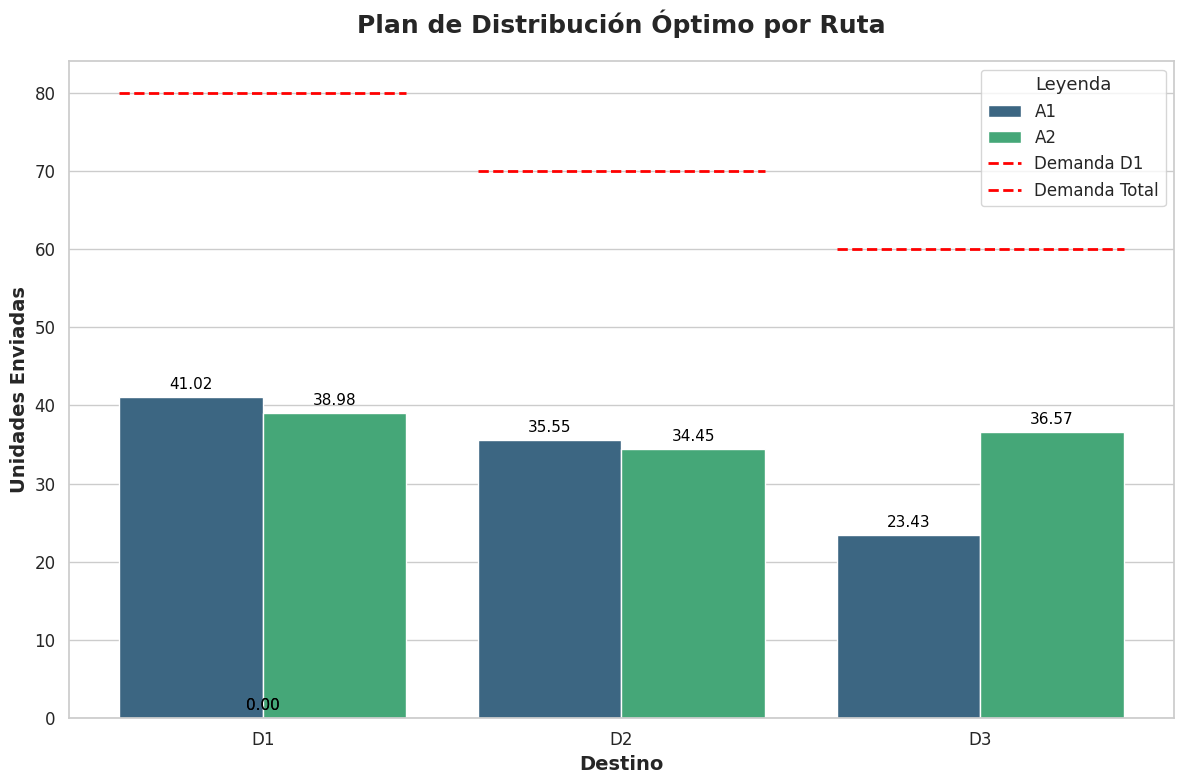

In [63]:
# ===================================================================
# CELDA FINAL: VISUALIZACIÓN DE LA SOLUCIÓN ÓPTIMA
# ===================================================================

# --- 1. Preparación de los Datos ---
# Extraemos los resultados del modelo de Pyomo a un formato limpio
# para poder graficarlos fácilmente. Un DataFrame de Pandas es ideal.

plot_data = []
for (i, j), var in model.x.items():
    # Solo incluimos las rutas que tienen un flujo de envío significativo
    if var.value > 0.001:
        plot_data.append({
            'Origen': i,
            'Destino': j,
            'Cantidad': var.value
        })

df_plot = pd.DataFrame(plot_data)

# --- 2. Creación del Gráfico ---
# Configuramos el estilo del gráfico para una apariencia profesional y moderna.
sns.set_theme(style="whitegrid")

# Creamos la figura y los ejes con un tamaño adecuado.
fig, ax = plt.subplots(figsize=(12, 8))

# Generamos el gráfico de barras agrupadas.
# - Eje X: Los destinos
# - Eje Y: La cantidad de unidades enviadas
# - Hue (color): El almacén de origen, para agrupar las barras.
barplot = sns.barplot(
    data=df_plot,
    x='Destino',
    y='Cantidad',
    hue='Origen',
    palette='viridis', # Una paleta de colores atractiva y accesible
    ax=ax
)

# --- 3. Mejora y Personalización del Gráfico ---
# Añadimos detalles para que la gráfica sea más clara.

# Título principal y etiquetas de los ejes con formato.
ax.set_title(
    'Plan de Distribución Óptimo por Ruta',
    fontsize=18,
    fontweight='bold',
    pad=20
)
ax.set_xlabel('Destino', fontsize=14, fontweight='bold')
ax.set_ylabel('Unidades Enviadas', fontsize=14, fontweight='bold')

# Añadimos etiquetas con el valor exacto sobre cada barra.
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.2f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 9),
        textcoords='offset points',
        fontsize=11,
        color='black',
        fontweight='medium'
    )

# Mejoramos la leyenda.
ax.legend(
    title='Almacén de Origen',
    fontsize=12,
    title_fontsize=13,
    loc='upper right'
)

# Ajustamos el tamaño de las etiquetas de los ejes.
ax.tick_params(axis='both', which='major', labelsize=12)

# Añadimos una línea horizontal para la demanda total de cada destino como referencia
# Esto es opcional, pero añade mucho contexto.
demandas_df = pd.DataFrame(list(demandas.items()), columns=['Destino', 'Demanda'])
for index, row in demandas_df.iterrows():
    ax.hlines(
        y=row['Demanda'],
        xmin=index-0.4,
        xmax=index+0.4,
        colors='red',
        linestyles='--',
        lw=2,
        label=f'Demanda {row["Destino"]}' if index == 0 else ""
    )
# Evitar leyendas duplicadas para las líneas de demanda
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# Adicionamos la linea de demanda a la leyenda
by_label['Demanda Total'] = plt.Line2D([0], [0], color='red', linestyle='--', lw=2)


ax.legend(by_label.values(), by_label.keys(), title='Leyenda', fontsize=12, title_fontsize=13, loc='upper right')



# --- 4. Mostrar el Gráfico ---
# Usamos tight_layout para asegurar que todo encaje perfectamente.
plt.tight_layout()
plt.show()

---
## 9. Conclusiones

### 9.1 Hallazgos Principales

Este modelo de optimización con costos cuadráticos revela insights importantes sobre la distribución óptima:

1. **Diversificación de rutas:** La penalización cuadrática incentiva distribuir la carga entre múltiples rutas en lugar de saturar las más baratas, reflejando mejor la realidad operativa.

2. **Balance costo-volumen:** Las soluciones óptimas balancean el costo base de las rutas con la penalización cuadrática por volumen, evitando envíos excesivamente grandes en una sola ruta.

3. **Utilización eficiente:** El modelo encuentra el equilibrio óptimo entre utilizar la capacidad disponible y minimizar costos, respetando todas las restricciones operativas.

### 9.2 Ventajas del Modelo Cuadrático

**Comparado con modelos lineales tradicionales:**
- ✅ Representa mejor los costos marginales crecientes
- ✅ Evita soluciones de "todo o nada" poco realistas
- ✅ Captura efectos de congestión y deseconomías de escala
- ✅ Produce planes de distribución más robustos y operativamente viables

### 9.3 Aplicaciones Prácticas

Este enfoque es especialmente útil en:
- **Logística urbana:** Donde la congestión penaliza envíos masivos
- **Cadenas de suministro:** Con múltiples puntos de distribución
- **Gestión de inventarios:** Donde almacenar grandes volúmenes tiene costos crecientes
- **Redes de transporte:** Con capacidades limitadas y efectos de congestión

### 9.4 Consideraciones Finales

La solución obtenida representa un **óptimo global** (bajo condiciones de convexidad del problema cuadrático), proporcionando un plan de distribución que minimiza costos mientras respeta todas las restricciones operativas.

**Recomendación prescriptiva:** Implementar el plan de distribución encontrado, monitoreando que los supuestos del modelo (especialmente los coeficientes de penalización) reflejen adecuadamente la realidad operativa. Si las condiciones cambian, el modelo puede recalibrarse fácilmente modificando los parámetros.

---
## Referencias y Recursos Adicionales

- **Pyomo Documentation:** https://pyomo.readthedocs.io/
- **IPOPT Solver:** https://coin-or.github.io/Ipopt/
- **Nonlinear Programming:** Nocedal, J., & Wright, S. J. (2006). Numerical Optimization